In [1]:
import numpy as np
import torch
from torch.utils.data import random_split
import matplotlib.pyplot as plt
from model.unet import Unet
from model.diffusion import Diffusion_Models
from model.dataset import SpritesDataset
from train import train

# training hyperparameters
BATCH_SIZE = 128
EPOCHS = 100
LR = 1e-3
# network hyperparameters
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
N_FEAT = 64 # 64 hidden dimension feature
N_CFEAT = 5 # label vector is of size 5
HEIGHT = 16 # 16x16 image
SAVE_DIR = './weights/'
GEN_DIR = './generated_images/'
# diffusion hyperparameters
TIMESTEPS = 500

# DataSet path
dataset_data_path = './dataset/sprites_1788_16x16.npy'
dataset_label_path = './dataset/sprite_labels_nc_1788_16x16.npy'
LABELS = {'hero':       [1,0,0,0,0], 
          'non-hero':   [0,1,0,0,0], 
          'food':       [0,0,1,0,0], 
          'spell':      [0,0,0,1,0], 
          'side-facing':[0,0,0,0,1]}

c:\Users\david\miniconda3\envs\PyTorch\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Entrenamiento

In [ ]:
model = Unet(in_channels=3, n_feat=N_FEAT, n_cfeat=N_CFEAT, height=HEIGHT).to(DEVICE)
#model.load_state_dict(torch.load(SAVE_DIR+"model_sprites_101.pth", map_location=DEVICE))
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
df = Diffusion_Models(TIMESTEPS)

dataset = SpritesDataset(dataset_data_path, dataset_label_path)
generator1 = torch.Generator().manual_seed(42)
train_dataset, validation_dataset = random_split(dataset, [79400,10000], generator=generator1)

train(model, df, optimizer, train_dataset, validation_dataset, BATCH_SIZE, EPOCHS, DEVICE)

## Generación

In [2]:
dataset = SpritesDataset(dataset_data_path, dataset_label_path)
df = Diffusion_Models(TIMESTEPS)
model = Unet(in_channels=3, n_feat=N_FEAT, n_cfeat=N_CFEAT, height=HEIGHT).to(DEVICE)
model.load_state_dict(torch.load(SAVE_DIR+"model_sprites_051.pth", map_location=DEVICE))
model.eval()

def draw_samples(samples, ctx, filename='image', cols=2):
    samples = samples.to("cpu")
    rows = samples.shape[0] // cols
    if samples.shape[0]%cols!=0:
        rows += 1
    plt.figure(figsize=(cols*3,rows*3))
    for i, curr_imgs in enumerate(samples):
        curr_img = df.unorm(curr_imgs)
        plt.subplot(rows, cols, i + 1)
        plt.axis('off')
        plt.title(list(LABELS.keys())[np.argmax(ctx[i])])
        plt.imshow(curr_img.permute(1,2,0))
    plt.savefig(GEN_DIR + f'{filename}.png')
    plt.show()
    plt.close()

def makeMask(img, x1, x2, y1, y2):
    masks = torch.zeros(img.shape[:])
    masks[:,:,x1:x2,y1:y2] = 1
    return masks

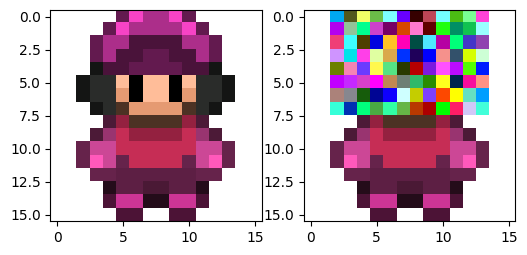

In [3]:
img, label = dataset[5364]
noise = torch.randn(size=(3, HEIGHT, HEIGHT))
mask = torch.zeros(img.shape[:])
mask[:,0:8,2:14] = 1
mask_inv = torch.ones(img.shape[:])
mask_inv -= mask

sample = noise*mask + img*mask_inv

plt.figure(figsize=(6,3))
plt.subplot(1, 2, 1)
plt.imshow(df.unorm(img.permute(1,2,0)))
plt.subplot(1, 2, 2)
plt.imshow(df.unorm(sample.permute(1,2,0)))
plt.show()

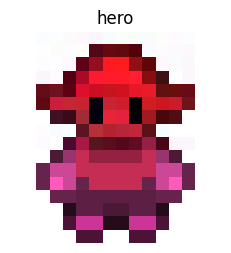

In [18]:
img, label = dataset[5364]
ctx = torch.tensor([LABELS['hero']]).float().to(DEVICE)

samples = img.reshape(-1,3,16,16).to(DEVICE)
masks = makeMask(samples, 0,9, 2,14)
samples = df.sample_ddpm_context(model, ctx.shape[0], ctx, samples=samples, end_timestep=TIMESTEPS, mask=masks)
draw_samples(samples,ctx.cpu())